In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

palette = sns.cubehelix_palette()
custom_params = {"axes.grid": False}
sns.set_theme(style="ticks", palette=palette, rc=custom_params)
sns.set_context("talk")
plt.rcParams.update({"figure.autolayout": True})

seed = 42
np.random.seed(seed=seed)

In [3]:
pal = sns.cubehelix_palette(rot=0.2)
print(pal.as_hex()[:])
pal.as_hex()

['#eccde5', '#d0a2cf', '#ab7db6', '#825c98', '#543d71', '#28203f']


['#eccde5', '#d0a2cf', '#ab7db6', '#825c98', '#543d71', '#28203f']

In [4]:
def confidence(p):
    if len(p.shape) > 1:
        u = np.array(
            [[1.0 / p.shape[1] for j in range(p.shape[1])] for i in range(p.shape[0])]
        )
    else:
        u = np.array([1.0 / p.shape[0] for j in range(p.shape[0])])
    return np.sum(u * np.log(u / p), axis=-1)


def entropy(p):
    return -np.sum(p * np.log(p), axis=-1)


def misclass_error(p, y):
    if len(p.shape) > 1:
        return 1 - p[(np.arange(p.shape[0]), y)]
    else:
        return 1 - p[y]


def criterion(p):
    return -np.log(p).mean(axis=-1)


def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / exp_logits.sum(axis=-1, keepdims=True)


def taylor(logits):
    exp_logits = 1 + logits + (logits**2) / 2
    return exp_logits / exp_logits.sum(axis=-1, keepdims=True)

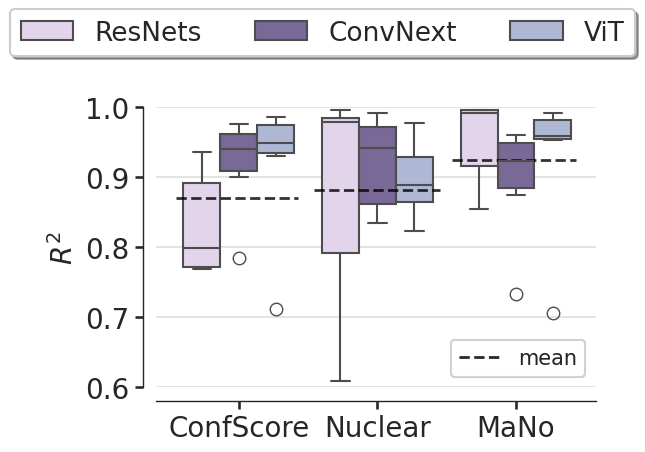

In [4]:
fontsize = 20
save = True
path = "figures"
dpi = 100
format = "pdf"
figname = f"boxplot_all_arch.{format}"
figsize = (6, 4)
fig = plt.figure(figsize=figsize)

# Fill dictionnary
xname = ""
yname = "$R^2$"
huename = "model"
method_name = ["ConfScore", "Nuclear", "MaNo"]
model_name = ["ResNets", "ConvNext", "ViT"]
a = [
    [0.916, 0.936, 0.437, 0.768, 0.817, 0.781],
    [0.936, 0.976, 0.900, 0.784, 0.943, 0.968],
    [0.985, 0.983, 0.711, 0.947, 0.930, 0.950],
]
b = [
    [0.995, 0.977, 0.609, 0.730, 0.985, 0.981],
    [0.991, 0.982, 0.834, 0.514, 0.941, 0.942],
    [0.937, 0.977, 0.823, 0.861, 0.873, 0.905],
]
c = [
    [0.996, 0.996, 0.891, 0.854, 0.993, 0.989],
    [0.916, 0.954, 0.874, 0.733, 0.930, 0.960],
    [0.991, 0.989, 0.705, 0.953, 0.958, 0.959],
]
mu_a = np.mean(np.asarray(a))
mu_b = np.mean(np.asarray(b))
mu_c = np.mean(np.asarray(c))
values = np.array([a, b, c])
dict_df = {xname: [], yname: [], huename: []}
for i, method in enumerate(method_name):
    for j, model in enumerate(model_name):
        for k in range(len(a[0])):
            val = values[i, j, k]
            dict_df[xname].append(method)
            dict_df[yname].append(val)
            dict_df[huename].append(model)

df = pd.DataFrame(dict_df)
ax_sns = sns.boxplot(
    data=df,
    x=xname,
    y=yname,
    hue=huename,
    palette=["#e3d0ef", "#76619e", "#a7b5dc"],
    legend=True,
    linewidth=1.5,
)
ax = fig.axes[0]
ax.legend().set_title("")
ax_sns.set_ylabel(yname, fontsize=fontsize)
ax.legend_.remove()
ax.spines["left"].set_linewidth(1)
ax.spines["right"].set_linewidth(1)
ax.spines["top"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(direction="out", length=6)
ax.set_ylim(0.60, 1)
sns.despine(fig, ax, trim=False, right=True, offset=10)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.yaxis.grid(alpha=0.6, lw=1.3)

# Common legend
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(
    lines,
    labels,
    loc="upper center",  # "center",
    bbox_to_anchor=(0.5, 1.15),
    fancybox=True,
    borderaxespad=0,
    shadow=True,
    ncol=4,
    fontsize=19,
)

# Vertical mean
ls = "--"
cl = "black"
lw = 2
alpha = 0.8
hline = plt.hlines(
    y=mu_a,
    xmin=-0.45,
    xmax=0.43,
    linestyle=ls,
    color=cl,
    linewidth=lw,
    alpha=alpha,
    label="mean",
)
plt.hlines(
    y=mu_b, xmin=0.54, xmax=1.45, linestyle=ls, color=cl, linewidth=lw, alpha=alpha
)
plt.hlines(
    y=mu_c, xmin=1.54, xmax=2.43, linestyle=ls, color=cl, linewidth=lw, alpha=alpha
)
legend1 = plt.legend([hline], ["mean"], loc="lower right", fontsize=15)
plt.gca().add_artist(legend1)
plt.tight_layout()
if save:
    if figname is None:
        figname = f"missing_title.{format}"
    plt.savefig(
        os.path.join(path, figname), format=format, bbox_inches="tight", dpi=dpi
    )
plt.show()

In [5]:
crit_maxs = []
crit_mins = []
crit_perclow = []
crit_perchigh = []
values = np.arange(2, 101)
p_min = 0.5
p_max = 99.5
for K in values:
    logit_max = 5
    logits = np.random.uniform(-logit_max, logit_max, (100000, K))
    p = softmax(logits)
    crit = criterion(p)
    crit_mins.append(crit.min())
    crit_maxs.append(crit.max())
    crit_perclow.append(np.percentile(crit, p_min))
    crit_perchigh.append(np.percentile(crit, p_max))

<>:37: SyntaxWarning: invalid escape sequence '\P'
<>:37: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_393/305010766.py:37: SyntaxWarning: invalid escape sequence '\P'
  plt.ylabel("Criterion $\Phi(D_{test})$")


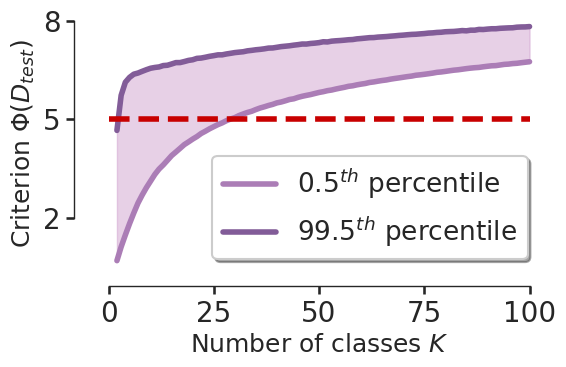

In [15]:
fontsize = 20
save = True
path = "figures"
dpi = 100
format = "pdf"
figname = f"criterion.{format}"
figsize = (6, 4)
fig = plt.figure(figsize=figsize)

lw = 4
ls = "-"
plt.plot(
    values,
    crit_perclow,
    color="#ab7db6",
    label="$0.5^{th}$ percentile",
    linewidth=lw,
    linestyle=ls,
)
plt.plot(
    values,
    crit_perchigh,
    color="#825c98",
    label="$99.5^{th}$ percentile",
    linewidth=lw,
    linestyle=ls,
)
plt.fill_between(
    values,
    crit_perclow,
    crit_perchigh,
    color="#d0a2cf",
    linewidth=1,
    alpha=0.5,
)
plt.xlabel("Number of classes $K$")
plt.ylabel("Criterion $\Phi(D_{test})$")

ax = fig.axes[0]
ax.spines["left"].set_linewidth(1)
ax.spines["right"].set_linewidth(1)
ax.spines["top"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(direction="out", length=6)
sns.despine(fig, ax, trim=True, right=True, offset=10)
ax.tick_params(axis="both", which="major", labelsize=20)
# ax.grid(alpha=0.6, lw=1.3)
xticks = [0, 25, 50, 75, 100]
plt.hlines(
    y=5, xmin=xticks[0], xmax=xticks[-1], linewidth=lw, linestyle="--", color="#c80000"
)
ax.set_xticks(xticks)
yticks = [2, 5, 8]
ax.set_yticks(yticks)

# Common legend
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(
    lines,
    labels,
    loc="upper center",  # "center",
    bbox_to_anchor=(0.645, 0.57),
    fancybox=True,
    borderaxespad=0,
    shadow=True,
    ncol=1,
    fontsize=19,
)

plt.tight_layout()
if save:
    if figname is None:
        figname = f"missing_title.{format}"
    plt.savefig(
        os.path.join(path, figname), format=format, bbox_inches="tight", dpi=dpi
    )
plt.show()